In [1]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import json
from tqdm import tqdm
import torch.optim as optim
import yaml
import pickle
from torch.utils.data import Dataset, DataLoader

Carico il configuratore che tiene traccia di tutte le informazioni generali 

In [43]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
with open("./config.yaml", 'r') as f:
    config = yaml.safe_load(f)

# Download Dati

In questa parte carico i `.csv` e gli organizzo in modo tale che siano ordinati per

`(data, denominazione_regionale, denominazione_provincia)`

Inoltre pulisco i vari datase poiché ci sono una serie di righe che presentano delle problematicità in termini di valori.

La matrice di adiacenza generale è stata creata connettendo tutte le provincie di una determinata regione, in modo tale da mantenere una similitudine con il problema originario. Inoltre, per non distaccarsi troppo con la realtà, sono state inserite delle connessioni tra regioni dato che quest'ultime non sono isolate. In particolare sono state aggiunte connessioni tra tutti i capoluoghi.

In [3]:
def get_adj(config: yaml):
    if os.path.exists(os.path.join(config['paths']['adj'],"adj_totale.pkl")):
        with open(os.path.join(config['paths']['adj'],"adj_totale.pkl"), "rb") as f:
            adj = pickle.load(f)
    else:
        codice_reg_prov = pd.read_csv(os.path.join(config['paths']['data'], "codice_reg_prov.csv"), index_col=0)

        # Carico un dizionario in cui le chiavi sono le regioni e i valori sono i rispettivi capoluohi
        with open(os.path.join(config['paths']['data'], "capoluoghi.json"), 'r') as f:
            capoluoghi = json.load(f)
        
        adjs = {}
        adj = np.zeros((len(codice_reg_prov), len(codice_reg_prov)))
        i = 0
        index_capoluoghi = []
        d = codice_reg_prov.groupby('denominazione_provincia').codice_provincia.max().to_dict()
        regioni = codice_reg_prov.groupby(by=['codice_regione']).codice_provincia.unique()
        
        for cod_reg in tqdm(regioni.index):
            codici_provincia = regioni[cod_reg]
            n_prov = len(codici_provincia)
            adjs[cod_reg] = np.ones((n_prov, n_prov))-np.eye(n_prov)
            adj[i:i+n_prov, i:i+n_prov] = adjs[cod_reg]

            region = codice_reg_prov[codice_reg_prov.codice_regione==cod_reg].denominazione_regione.values[0]
            codice_capoluogo = codice_reg_prov[codice_reg_prov.denominazione_provincia==capoluoghi[region]].codice_provincia.values[0]
            pos = np.where(codici_provincia == codice_capoluogo)[0][0]
            index_capoluoghi.append(i+pos)
            
            
            with open(os.path.join(config['paths']['adj'],f"adj_{region}.pkl"), "wb") as f:
                pickle.dump(adj, f)
                
            i += n_prov
        for ind_r in index_capoluoghi:
            for ind_c in index_capoluoghi:
                if ind_r != ind_c:
                    adj[ind_r, ind_c] = 1
                
        with open(os.path.join(config['paths']['adj'],"adj_totale.pkl"), "wb") as f:
            pickle.dump(adj, f)
        
    return adj


In [58]:
def fill_dataset(df: pd, 
                 config:yaml):
    # questa procedura serve solo ad inserire i dati sulle province mancanti
    d = []
    feat = df.shape[1]
    codici = list(df.codice_provincia.unique())
    codice_reg_prov = {tuple(x) for x in df[config['dataset']['col_categorical_prov']].values.tolist()}
    codice_reg_prov = pd.DataFrame(codice_reg_prov, columns=config['dataset']['col_categorical_prov'])
    
    for data in tqdm(df.data.unique(), desc = "filling"):
        tmp = df[df.data == data]
        if len(tmp) == len(codici):
            d.append(tmp)
        else:
            # individue le province mancanti
            codici_mancanti = [x for x in codici if x not in list(tmp.codice_provincia.unique())]
            code_regioni_mancanti = [codice_reg_prov[codice_reg_prov.codice_provincia == x].codice_regione.values[0] for x in codici_mancanti]
            tmp_mancante = pd.DataFrame(np.zeros((len(codici_mancanti),feat)), columns = df.columns)
            
            tmp_mancante.data = data
            tmp_mancante.codice_provincia = codici_mancanti
            tmp_mancante.codice_regione = code_regioni_mancanti
            tmp = pd.concat((tmp, tmp_mancante))
            
            if len(tmp) != len(codice_reg_prov):
                import pdb
                pdb.set_trace()
            d.append(tmp)
    df = pd.concat(d)

    #df = df[config['dataset']['col_data'] + config['dataset']['col_numerical_prov']+  config['dataset']['col_numerical_reg']+config['dataset']['col_categorical_prov']]
    df = df.drop(columns=["denominazione_regione", "denominazione_provincia"])
    df = df.sort_values(by = config['dataset']['ordering']).drop_duplicates(config['dataset']['ordering']).reset_index(drop = True)
    
    ## normalization for each region
    # d = []
    # col = config['dataset']['numerical']
    # remaining = [x for x in list(df.columns) if (x not in col)&(x!='data')]
    # for cod in df.codice_regione.unique():
    #     tmp = df[df.codice_regione==cod]        
    #     index = int(len(tmp)*0.8)
    #     for column in col:
    #         min = tmp[column].values[:index].min()
    #         max = tmp[column].values[:index].max()
    #         tmp[column] = (tmp[column]-min)/(max-min)            
        
    #     d.append(tmp)
        
    # tmp = pd.concat(d,0)
    df = tmp.sort_values(by = ['data', 'codice_provincia']).reset_index(drop = True)  
    return df
    
def get_dataset(config: yaml):
    files = ["covid", "codice_reg_prov", "covid_province", "covid_regioni"]
    exists = [os.path.exists(os.path.join(config['paths']['data'], f"{file}.csv")) for file in files]


    ############## Checking if all the files that I need exists #######################
    if  np.all(exists):
        out = ()
        for file in files:
            tmp = pd.read_csv(os.path.join(config['paths']['data'], f"{file}.csv"), index_col=0)
            if "data" in list(tmp.columns):
                tmp['data'] = pd.to_datetime(tmp['data'], format='%Y-%m-%d')
            out += (tmp,)
        return out[0], out[1]
        
    else:
        ########## I create take the dataset for the provinces
        if os.path.exists(os.path.join(config['paths']['data'],"covid_province.csv")):
            provincials = pd.read_csv(os.path.join(config['paths']['raw_data'],"covid_province.csv"), index_col = 0)
            provincials['data'] = pd.to_datetime(provincials['data'], format='%Y-%m-%d')
        else:
            data = []
            for csv in tqdm(os.listdir(os.path.join(config['paths']['raw_data'],"dati-province")), desc = "provincia"):
                if csv.split(".")[-1] == "csv":
                    tmp = pd.read_csv(os.path.join(config['paths']['raw_data'],"dati-province",csv), 
                                      usecols = ['data', 'codice_regione', 'codice_provincia', 'totale_casi'])
                    data.append(tmp)
            
            data = pd.concat(data)
            data.reset_index(drop = True, inplace=True)
            data.data = data.data.apply(lambda x: x.split("T")[0])
            data.data = pd.to_datetime(data['data'], format='%Y-%m-%d')
            
            # Riduco il dataset con le variabili che servono
            # Inoltre trasformo la conta totale dei positivi per ogni regione in nuovi positivi
            data.rename(columns={'totale_casi': 'nuovi_casi'}, inplace=True)
            provincials = data.drop_duplicates()
            provincials = provincials[-(provincials.codice_provincia>200)]
            provincials = provincials[-provincials.codice_regione.isin([21,22])].reset_index(drop = True)
            
            tmp = provincials[['data','codice_provincia', 'nuovi_casi']]
            tmp = tmp.groupby('codice_provincia').diff().dropna().drop(columns = "data")
            # Non ha senso avere questi valori
            tmp = tmp[-tmp.nuovi_casi<0]
            
            #faccio un merge sugli indici
            provincials = pd.merge(provincials.drop(columns = "nuovi_casi"),tmp, left_index=True, right_index=True)
            provincials = provincials.reset_index(drop=True)
            provincials.to_csv(os.path.join(config['paths']['data'],"covid_province.csv"))

                    
        if os.path.exists(os.path.join(config['paths']['data'], "covid_regioni.csv")):
            regions = pd.read_csv(os.path.join(config['paths']['data'],"covid_regioni.csv"), index_col=0)
            regions['data'] = pd.to_datetime(regions['data'], format='%Y-%m-%d')
        else:
            ########## I create take the dataset for the regions
            data = []
            for csv in tqdm(os.listdir(os.path.join(config['paths']['raw_data'],"dati-regioni")), desc = "regione"):
                if csv.split(".")[-1] == "csv":
                    data.append(pd.read_csv(os.path.join(config['paths']['raw_data'],"dati-regioni",csv)))
            data = pd.concat(data).reset_index(drop = True)
            
            # Trento
            data.codice_regione = data.codice_regione.replace(21, 4)
            # Bolzano
            data.codice_regione = data.codice_regione.replace(22, 4)
            data.denominazione_regione = data.denominazione_regione.replace(['P.A. Bolzano', 'P.A. Trento'], "Trentino")
            
            regions = data[['data', 'codice_regione', 'ricoverati_con_sintomi', 'terapia_intensiva', 'totale_ospedalizzati',
               'isolamento_domiciliare', 'dimessi_guariti', 'deceduti']]
            regions.data = regions.data.apply(lambda x: x.split("T")[0])
            regions.data = pd.to_datetime(regions['data'], format='%Y-%m-%d')
            
            regions = regions.drop_duplicates().reset_index(drop = True)
            regions.to_csv(os.path.join(config['paths']['data'],"covid_regioni.csv"))
                    
        # Creo il dataset completo 
        if os.path.exists(os.path.join(config['paths']['data'],"covid.csv")):
            df = pd.read_csv(os.path.join(config['paths']['data'], "covid.csv"), index_col=0)
            df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d')

        else:
            df = pd.merge(provincials, regions, 
                          how = "left",  
                          on = ['data','codice_regione']) 
            import pdb
            pdb.set_trace()
            df = df.sort_values(by = ['data','codice_regione', 'codice_provincia']).drop_duplicates(['data','codice_provincia']).reset_index(drop = True)
            
            #df = df[config['dataset']['col_data'] + config['dataset']['col_numerical_prov']+config['dataset']['col_numerical_reg']+config['dataset']['col_categorical_prov']]

            codice_reg_prov = {tuple(x) for x in df[config['dataset']['col_categorical_prov']].values.tolist()}
            codice_reg_prov = pd.DataFrame(codice_reg_prov, columns=config['dataset']['col_categorical_prov'])

            ################# Filling the dataset ###################
            df = fill_dataset(df, config)

            ################# Date variables ########################
            df['year'] = df.data.dt.year
            df['month'] = df.data.dt.month
            df['day'] = df.data.dt.day

            ################# Saving the dataset #####################
            codice_reg_prov.to_csv(os.path.join(config['paths']['data'],"codice_reg_prov.csv"))
            df.to_csv(os.path.join(config['paths']['data'],"covid.csv"))
            
    return df
    
df = get_dataset(config)


> /tmp/ipykernel_37312/3531839984.py(140)get_dataset()
    138             import pdb
    139             pdb.set_trace()
--> 140             df = df.sort_values(by = ['data','codice_regione', 'codice_provincia']).drop_duplicates(['data','codice_provincia']).reset_index(drop = True)
    141 
    142             #df = df[config['dataset']['col_data'] + config['dataset']['col_numerical_prov']+config['dataset']['col_numerical_reg']+config['dataset']['col_categorical_prov']]



ipdb>  provincials.columns


Index(['data', 'codice_regione', 'denominazione_regione', 'codice_provincia',
       'denominazione_provincia', 'nuovi_casi'],
      dtype='object')


ipdb>  provincials[provincials.isna()]


       data  codice_regione denominazione_regione  codice_provincia  \
0       NaT             NaN                   NaN               NaN   
1       NaT             NaN                   NaN               NaN   
2       NaT             NaN                   NaN               NaN   
3       NaT             NaN                   NaN               NaN   
4       NaT             NaN                   NaN               NaN   
...     ...             ...                   ...               ...   
127263  NaT             NaN                   NaN               NaN   
127264  NaT             NaN                   NaN               NaN   
127265  NaT             NaN                   NaN               NaN   
127266  NaT             NaN                   NaN               NaN   
127267  NaT             NaN                   NaN               NaN   

       denominazione_provincia  nuovi_casi  
0                          NaN         NaN  
1                          NaN         NaN  
2           

ipdb>  len(provincials)


127268


ipdb>  proviancials


*** NameError: name 'proviancials' is not defined


ipdb>  provincials#[provincials.isna()]


             data  codice_regione denominazione_regione  codice_provincia  \
0      2020-02-25               1              Piemonte                 1   
1      2020-02-25               3             Lombardia                14   
2      2020-02-25               3             Lombardia                15   
3      2020-02-25               3             Lombardia                16   
4      2020-02-25               3             Lombardia                18   
...           ...             ...                   ...               ...   
127263 2023-09-13              20              Sardegna                90   
127264 2023-09-13              20              Sardegna                91   
127265 2023-09-13              20              Sardegna                92   
127266 2023-09-13              20              Sardegna                95   
127267 2023-09-13              20              Sardegna               111   

       denominazione_provincia  nuovi_casi  
0                       Torino

ipdb>  q


In [69]:
data = []
for csv in tqdm(os.listdir(os.path.join(config['paths']['raw_data'],"dati-province")), desc = "provincia"):
    if csv.split(".")[-1] == "csv":
        tmp = pd.read_csv(os.path.join(config['paths']['raw_data'],"dati-province",csv), 
                          usecols = ['data', 'codice_regione', 'codice_provincia', 'totale_casi'])
        data.append(tmp)

data = pd.concat(data)
data.reset_index(drop = True, inplace=True)
data.data = data.data.apply(lambda x: x.split("T")[0])
data.data = pd.to_datetime(data['data'], format='%Y-%m-%d')

# Riduco il dataset con le variabili che servono
# Inoltre trasformo la conta totale dei positivi per ogni regione in nuovi positivi
data.rename(columns={'totale_casi': 'nuovi_casi'}, inplace=True)
provincials = data.drop_duplicates()
provincials = provincials[-(provincials.codice_provincia>200)]

# codici relative alle province che sono state male elaborate
provincials = provincials[-provincials.codice_regione.isin([21,22])].reset_index(drop = True)

tmp = provincials[['data','codice_provincia', 'nuovi_casi']]
tmp = tmp.groupby('codice_provincia').diff().dropna().drop(columns = "data")
# Non ha senso avere questi valori
tmp = tmp[-tmp.nuovi_casi<0]

# #faccio un merge sugli indici
# provincials = pd.merge(provincials.drop(columns = "nuovi_casi"),tmp, left_index=True, right_index=True)
# provincials = provincials.reset_index(drop=True)
# provincials.to_csv(os.path.join(config['paths']['data'],"covid_province.csv"))

provincia: 100%|███████████████████████████| 1301/1301 [00:01<00:00, 783.94it/s]


In [120]:
provincials = provincials[['data','codice_provincia', 'nuovi_casi']].sort_values(by = 'data')

In [142]:
d = []
for id in provincials.codice_provincia.unique():
    tmp = provincials[provincials.codice_provincia == id].sort_values(by='data')
    tmp[['diff_data', 'nuovi_casi']] = tmp[['data', 'nuovi_casi']].diff()
    d.append(tmp.dropna())
tmp = pd.concat(d, ignore_index=True)

In [144]:
tmp[tmp.diff_data == np.timedelta64(1, 'D')]

,data,codice_provincia,nuovi_casi,diff_data
0,2020-02-25,43,0.0,1 days
1,2020-02-26,43,0.0,1 days
2,2020-02-27,43,0.0,1 days
3,2020-02-28,43,0.0,1 days
4,2020-02-29,43,0.0,1 days
...,...,...,...,...
138530,2023-09-09,21,14.0,1 days
138531,2023-09-10,21,5.0,1 days
138532,2023-09-11,21,7.0,1 days
138533,2023-09-12,21,41.0,1 days


In [82]:
nuovi={}
for i in range(1, len(provincials)):
    if provincials.data.values[i]-provincials.data.values[i-1] == np.timedelta64(1, 'D'):
        nuovi[provincials.data.values[i-1]] = provincials.nuovi_casi.values[i]-provincials.nuovi_casi.values[i]

In [84]:
tmp = pd.DataFrame(nuovi.items())

In [85]:
tmp

,0,1
0,2021-12-09,0
1,2023-01-23,0
2,2020-02-28,0
3,2020-02-29,0
4,2020-03-03,0
...,...,...
413,2023-09-07,0
414,2023-09-08,0
415,2023-09-09,0
416,2023-09-10,0


In [59]:
regions = pd.read_csv(os.path.join(config['paths']['data'],"covid_regioni.csv"), index_col=0)
regions['data'] = pd.to_datetime(regions['data'], format='%Y-%m-%d')
provincials = pd.read_csv(os.path.join(config['paths']['raw_data'],"covid_province.csv"), index_col = 0)
provincials['data'] = pd.to_datetime(provincials['data'], format='%Y-%m-%d')

In [60]:
provincials

,data,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,nuovi_casi
0,2020-02-25,1,Piemonte,1,Torino,3.0
1,2020-02-25,3,Lombardia,14,Sondrio,1.0
2,2020-02-25,3,Lombardia,15,Milano,8.0
3,2020-02-25,3,Lombardia,16,Bergamo,18.0
4,2020-02-25,3,Lombardia,18,Pavia,27.0
...,...,...,...,...,...,...
127263,2023-09-13,20,Sardegna,90,Sassari,35.0
127264,2023-09-13,20,Sardegna,91,Nuoro,14.0
127265,2023-09-13,20,Sardegna,92,Cagliari,41.0
127266,2023-09-13,20,Sardegna,95,Oristano,11.0


In [ ]:
df = pd.merge(provincials, regions, 
              how = "left",  
              on = ['data','codice_regione']) 


In [ ]:

df = df.sort_values(by = ['data','codice_regione', 'codice_provincia']).drop_duplicates(['data','codice_provincia']).reset_index(drop = True)

#df = df[config['dataset']['col_data'] + config['dataset']['col_numerical_prov']+config['dataset']['col_numerical_reg']+config['dataset']['col_categorical_prov']]

codice_reg_prov = {tuple(x) for x in df[config['dataset']['col_categorical_prov']].values.tolist()}
codice_reg_prov = pd.DataFrame(codice_reg_prov, columns=config['dataset']['col_categorical_prov'])

################# Filling the dataset ###################
df = fill_dataset(df, config)

################# Date variables ########################
df['year'] = df.data.dt.year
df['month'] = df.data.dt.month
df['day'] = df.data.dt.day

################# Saving the dataset #####################
codice_reg_prov.to_csv(os.path.join(config['paths']['data'],"codice_reg_prov.csv"))
df.to_csv(os.path.join(config['paths']['data'],"covid.csv"))

In [24]:
data = []
for csv in tqdm(os.listdir(os.path.join(config['paths']['raw_data'],"dati-province")), desc = "provincia"):
    if csv.split(".")[-1] == "csv":
        data.append(pd.read_csv(os.path.join(config['paths']['raw_data'],"dati-province",csv)))

data = pd.concat(data)
data.reset_index(drop = True, inplace=True)
data.data = data.data.apply(lambda x: x.split("T")[0])
data.data = pd.to_datetime(data['data'], format='%Y-%m-%d')

provincia: 100%|███████████████████████████| 1301/1301 [00:04<00:00, 308.70it/s]


In [56]:
df[df.isna()]

,data,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,nuovi_casi,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,dimessi_guariti,deceduti,year,month,day
0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
########## I create take the dataset for the regions
reg = []
for csv in tqdm(os.listdir(os.path.join(config['paths']['raw_data'],"dati-regioni")), desc = "regione"):
    if csv.split(".")[-1] == "csv":
        reg.append(pd.read_csv(os.path.join(os.path.join(config['paths']['raw_data'],"dati-regioni"),csv)))
reg = pd.concat(reg).reset_index(drop = True)

regione: 100%|█████████████████████████████| 1301/1301 [00:04<00:00, 318.75it/s]


In [12]:
tmp_reg = reg[['data', 'codice_regione', 'ricoverati_con_sintomi', 'terapia_intensiva', 'totale_ospedalizzati',
               'isolamento_domiciliare', 'dimessi_guariti', 'deceduti']]
tmp_reg.data = tmp_reg.data.apply(lambda x: x.split("T")[0])
tmp_reg.data = pd.to_datetime(tmp_reg['data'], format='%Y-%m-%d')

In [23]:
tmp_reg.head()

,data,codice_regione,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,dimessi_guariti,deceduti
0,2021-06-27,13,26,1,27,1002,71220,2512
1,2021-06-27,17,23,0,23,820,25500,590
2,2021-06-27,18,64,6,70,5439,62172,1224
3,2021-06-27,15,220,23,243,8758,407593,7433
4,2021-06-27,8,185,28,213,3510,369715,13257


In [43]:
data = []
for csv in tqdm(os.listdir(os.path.join(config['paths']['raw_data'],"dati-province")), desc = "provincia"):
    if csv.split(".")[-1] == "csv":
        data.append(pd.read_csv(os.path.join(config['paths']['raw_data'],"dati-province",csv)))

data = pd.concat(data)
data.data = data.data.apply(lambda x: x.split("T")[0])
data.data = pd.to_datetime(data['data'], format='%Y-%m-%d')
data = data[['data', 'codice_regione', 'codice_provincia', 'totale_casi']]

provincia: 100%|███████████████████████████| 1301/1301 [00:03<00:00, 349.57it/s]


In [33]:
common_date = list(data[data.data.isin(tmp_reg.data)].data.unique())

In [35]:
data[data.data.isin(common_date)]

,data,codice_regione,codice_provincia,totale_casi
0,2021-05-31,13,66,18668
1,2021-05-31,13,67,17271
2,2021-05-31,13,68,18070
3,2021-05-31,13,69,19273
4,2021-05-31,13,879,579
...,...,...,...,...
144,2020-12-13,5,27,27972
145,2020-12-13,5,28,35084
146,2020-12-13,5,29,5366
147,2020-12-13,5,899,3139


In [36]:
tmp = pd.merge(data[data.data.isin(common_date)], tmp_reg[tmp_reg.data.isin(common_date)], on = ['data','codice_regione'])

In [38]:
tmp.columns

Index(['data', 'codice_regione', 'codice_provincia', 'totale_casi',
       'ricoverati_con_sintomi', 'terapia_intensiva', 'totale_ospedalizzati',
       'isolamento_domiciliare', 'dimessi_guariti', 'deceduti'],
      dtype='object')

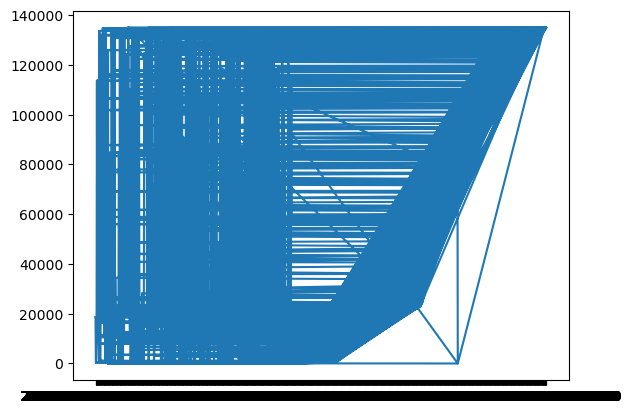

In [65]:
plt.plot(data[data.codice_provincia == 66].data, data[data.codice_provincia == 66].totale_casi)

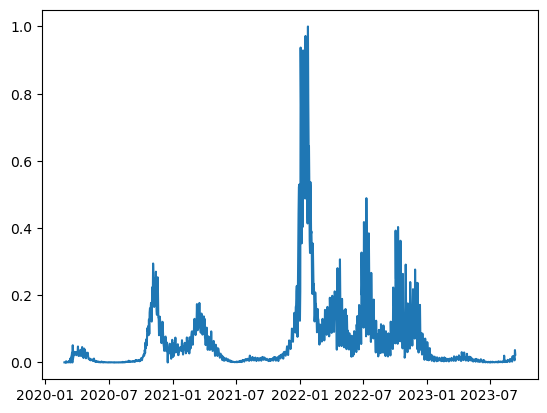

In [51]:
plt.plot(df.data.unique(), df[df.codice_provincia == 1].nuovi_casi)

In [44]:
adj = get_adj(config)

In [6]:
class dataset_gnn(Dataset):
    
    def __init__(self, 
                 df:pd,
                 y:pd,
                 adj: np.array,
                 past_step:int, 
                 future_step:int):
        """
        Arguments:
            df (pandas.Dataframe) : dataset to be processed.
            y (int) : target variable
            adj (np.array) : the static adiajency matrix 
            past_step (int): previous step to look back
            future_step (int): future step to look for
        """
        self.x = []
        self.y = []
        self.adj = adj
        
        n = len(df.codice_regione.unique())
        date = np.sort(df.data.unique())
        n_provincie = len(df.codice_provincia.unique())
        start = 0
        dt = np.diff(date[:past_step+future_step]) == np.timedelta64(1, 'D')
        while any(not x for x in dt):
            start +=1
            dt = np.diff(date[start:past_step+future_step+ start]) == np.timedelta64(1, 'D')
               
        for i in tqdm(range(start, len(date)-future_step-past_step-1)):
            if date[i+past_step+future_step]-date[i+past_step+future_step-1] == np.timedelta64(1, 'D'): 
                tmp_x = df[df.data.isin(date[i:i+past_step])].drop(columns = "data").values
                tmp_y = y[df.data.isin(date[i+past_step:i+past_step+future_step])].nuovi_casi.values

                self.x.append(tmp_x.reshape(past_step, n_provincie, -1))
                self.y.append(tmp_y.reshape(future_step, -1))
            else:
                i += past_step+future_step
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx], self.adj


In [ ]:
past_step = config['setting']['past_step']
future_step = config['setting']['future_step']

if not os.path.exists(os.path.join(config['paths']['data'],f"aggregate/dataset{past_step}_{future_step}.pt")):
    
    dataset = covid_dataset(df,
                            y,
                            adj = adj, 
                            past_step=past_step, 
                            future_step=future_step)

In [ ]:
with open( os.path.join(config['paths']['data'],f"aggregate/dataset{past_step}_{future_step}.pkl"), 'wb') as f:
    pickle.dump(dataset, f)

In [ ]:
for codice in df.codice_regione.unique()[:5]:    
    plt.plot(df[df.codice_regione == codice].data.unique(), 
             df[df.codice_regione == codice].groupby('data').sum().nuovi_casi,'p', 
             label = codice)
plt.legend()
plt.show()